In [1]:
"""
We will create a neural network that classifies Reuter news into 46 mutually exclusive topics. Since there are many classes to match
data point to, this problem is multiclass classification. Specifically, each data point matches to exactly one topic, so it is 
single-label, multiclass classification problem. If a news could be matched to multiple topic, it would become multi-label, multiclass
classification problem. In here, we will use Reuter dataset, which is a set of short news articles and topics. This dataset is included
in keras.
"""
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

#Like IMDB review, each sample is a list of integers (word indices)
print(train_data[0])

#Decoding reuter dataset to text
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


3
Epoch 1/20
16/16 [==============================] - 1s 75ms/step - loss: 2.6193 - accuracy: 0.4818 - val_loss: 1.7145 - val_accuracy: 0.6350
Epoch 2/20
16/16 [==============================] - 1s 35ms/step - loss: 1.4104 - accuracy: 0.7092 - val_loss: 1.2957 - val_accuracy: 0.7110
Epoch 3/20
16/16 [==============================] - 1s 36ms/step - loss: 1.0422 - accuracy: 0.7796 - val_loss: 1.1280 - val_accuracy: 0.7690
Epoch 4/20
16/16 [==============================] - 1s 36ms/step - loss: 0.8152 - accuracy: 0.8297 - val_loss: 1.0309 - val_accuracy: 0.7880
Epoch 5/20
16/16 [==============================] - 1s 36ms/step - loss: 0.6490 - accuracy: 0.8662 - val_loss: 0.9711 - val_accuracy: 0.7910
Epoch 6/20
16/16 [==============================] - 1s 36ms/step - loss: 0.5195 - accuracy: 0.8939 - val_loss: 0.9271 - val_accuracy: 0.8190
Epoch 7/20
16/16 [==============================] - 1s 36ms/step - loss: 0.4146 - accuracy: 0.9156 - val_loss: 0.8939 - val_accuracy: 0.8150
Epoch 8/20


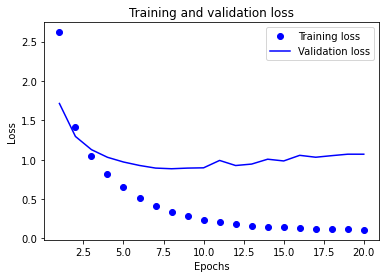

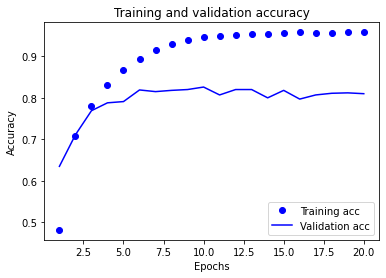

In [2]:
#Labels are topic's indices, integer ranged from 0 to 45
print(train_labels[10])

#Convert data into vector
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
"""
IMDB and Reuter dataset converted words in whole dataset to word indices before dividing the dataset into training data and test data.
Generally, we create word dictionary from training set then convert words in test set to word indices. This is because in real life we
do not know what words will be in the sample, so if we put words in test data in the dictionary beforehand, we are evaluating our test 
set optimistically.

There are two ways to convert label to vector. One is converting label list into integer tensor, and the other is using one-hot 
encoding. In here, we will use one-hot encoding.
"""

def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

"""
As we have seen before in MNIST example, there exists a function that does this in keras

from keras.utils.np_utils import to_categorical
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

This topic classification problems seems similar with the previous example of movie review classification problem. Both classifies a
short text. In here, we need to classify them to one of 46 topics rather than 2. This means that the number of output class increased
from 2 to 46.

If we stack Dense layer like before, each layer can only use information from output from the layer before it. If one layer omits some
information needed in distribution problem in its output, there is no way for the next layer to restore it. Each layer has potential to
become information bottleneck. We have used 16 dimension hidden layer, but it seems that 16 dimension is to restrictive to classify
46 classes. Small layers like this can act as a information bottleneck that loses useful information. Therefore, we will use bigger 
layer. Let's use 64 hidden units.
"""

from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

#This part is same as the example before: uses rmsprop as optimizer, uses categorical crossentropy as loss function, and monitors acc.
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#We will seperate 1000 samples from test datat to use as validation set
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

#Now we train the model with 20 epochs
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

#Drawing loss and accuracy curves
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [3]:
"""
This model starts overfitting after 9th epoch. We will train new model with 9 epochs and evaluate it in test set.
"""

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)
print(results)

Epoch 1/9
16/16 [==============================] - 1s 57ms/step - loss: 2.6514 - accuracy: 0.4283 - val_loss: 1.7135 - val_accuracy: 0.6490
Epoch 2/9
16/16 [==============================] - 1s 40ms/step - loss: 1.3910 - accuracy: 0.7122 - val_loss: 1.2814 - val_accuracy: 0.7070
Epoch 3/9
16/16 [==============================] - 1s 56ms/step - loss: 1.0221 - accuracy: 0.7791 - val_loss: 1.1137 - val_accuracy: 0.7630
Epoch 4/9
16/16 [==============================] - 1s 43ms/step - loss: 0.7999 - accuracy: 0.8321 - val_loss: 1.0147 - val_accuracy: 0.7850
Epoch 5/9
16/16 [==============================] - 1s 36ms/step - loss: 0.6343 - accuracy: 0.8680 - val_loss: 0.9413 - val_accuracy: 0.8040
Epoch 6/9
16/16 [==============================] - 1s 36ms/step - loss: 0.5131 - accuracy: 0.8953 - val_loss: 0.9265 - val_accuracy: 0.7970
Epoch 7/9
16/16 [==============================] - 1s 37ms/step - loss: 0.4103 - accuracy: 0.9141 - val_loss: 0.8950 - val_accuracy: 0.8150
Epoch 8/9
16/16 [===

In [4]:
"""
We have achieved approximately 79% accuracy. In this problem, if we just classify them randomly we get about 18% accuracy. It seems that
our result is better than just random
"""

import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
print(float(np.sum(hits_array)) / len(test_labels))

0.1918967052537845


In [5]:
"""
predict method of model object returns probability distribution about 46 topics. We will predict topics for all of the test data
"""

predictions = model.predict(x_test)

#Each of predictions[i] are vectors of length 46
print(predictions[0].shape)

#This vector above's sum of elements is 1
print(np.sum(predictions[0]))


#Class corresponding to index with the highest value, class with highest probability, becomes the prediction class.
print(np.argmax(predictions[0]))

(46,)
1.0000002
3


Epoch 1/20
63/63 [==============================] - 2s 32ms/step - loss: 3.2422 - accuracy: 0.1794 - val_loss: 2.6948 - val_accuracy: 0.2730
Epoch 2/20
63/63 [==============================] - 1s 17ms/step - loss: 2.2351 - accuracy: 0.3178 - val_loss: 1.8585 - val_accuracy: 0.6110
Epoch 3/20
63/63 [==============================] - 1s 17ms/step - loss: 1.4348 - accuracy: 0.6745 - val_loss: 1.4016 - val_accuracy: 0.6840
Epoch 4/20
63/63 [==============================] - 1s 17ms/step - loss: 1.1540 - accuracy: 0.7191 - val_loss: 1.3400 - val_accuracy: 0.6930
Epoch 5/20
63/63 [==============================] - 1s 22ms/step - loss: 1.0319 - accuracy: 0.7378 - val_loss: 1.3229 - val_accuracy: 0.6980
Epoch 6/20
63/63 [==============================] - 1s 22ms/step - loss: 0.9452 - accuracy: 0.7519 - val_loss: 1.3200 - val_accuracy: 0.6880
Epoch 7/20
63/63 [==============================] - 1s 21ms/step - loss: 0.8751 - accuracy: 0.7616 - val_loss: 1.3274 - val_accuracy: 0.6990
Epoch 8/20
63

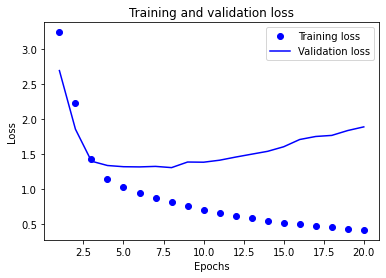

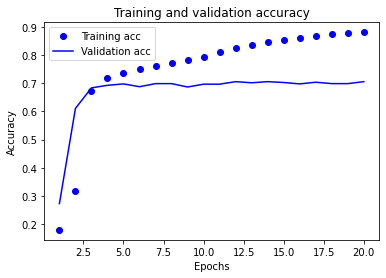

Epoch 1/7
63/63 [==============================] - 1s 22ms/step - loss: 3.0573 - accuracy: 0.2402 - val_loss: 2.6404 - val_accuracy: 0.2850
Epoch 2/7
63/63 [==============================] - 1s 17ms/step - loss: 2.1563 - accuracy: 0.4793 - val_loss: 1.8319 - val_accuracy: 0.6170
Epoch 3/7
63/63 [==============================] - 1s 17ms/step - loss: 1.4268 - accuracy: 0.6657 - val_loss: 1.5581 - val_accuracy: 0.6420
Epoch 4/7
63/63 [==============================] - 1s 17ms/step - loss: 1.1896 - accuracy: 0.7154 - val_loss: 1.4536 - val_accuracy: 0.6770
Epoch 5/7
63/63 [==============================] - 1s 17ms/step - loss: 1.0631 - accuracy: 0.7413 - val_loss: 1.4042 - val_accuracy: 0.6860
Epoch 6/7
63/63 [==============================] - 1s 17ms/step - loss: 0.9682 - accuracy: 0.7620 - val_loss: 1.4016 - val_accuracy: 0.7020
Epoch 7/7
71/71 [==============================] - 0s 5ms/step - loss: 1.4764 - accuracy: 0.6839
[1.4763838052749634, 0.683882474899292]


'\nValidation accuracy has decreased by \n'

In [7]:
"""
The other way to encode the labels is to convert it to integer tensor

y_train = np.array(train_labels)
y_test = np.array(test_labels)

To use this method, we can just change our loss function. categorical_crossentropy asserts that the labels are categorically encoded.
We need to use sparse_categorical_crossentropy when we are using integer labels.

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

This loss function is basically same as categorical_crossentropy; they just have difference in their interface.
"""

"""
As we have mentioned before, since the output has 46 dimensions, hidden units in the hidden layer shouldn't be less than 46. We will
check what would happen if we have hidden layer that has number of hidden units way smaller than 46.
"""

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=128, validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)
print(results)

plt.clf()

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(partial_x_train, partial_y_train, epochs=7, batch_size=128, validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)
print(results)

"""
Validation accuracy has decreased by 11%. Most of the reason for this is because we tried to compress a lot of information, enough to
restore partition hyperplane of 46 classes, into low dimension representation space of middle layer. This network crammed in most of the
needed information in 4 dimension representation, but could not put all of the needed information.
"""